In [12]:
import numpy as np
from joblib import load
from pathlib import Path
from xspec import AllModels, AllData, Model, Plot
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

from modules.network import r_squared



Model TBabs<1>(rdblur<2>*rfxconv<3>*comptb<4> + diskbb<5> + comptb<6>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
User entered plot commands:
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   rdblur     Betor10             -2.00000     frozen
   3    2   rdblur     Rin_M               10.0000      frozen
   4    2   rdblur     Rout_M              1000.00      frozen
   5    2   rdblur     Incl       deg      30.0000      +/-  0.0          
   6    3   rfxconv    rel_refl            -1.00000     +/-  0.0          
   7    3   rfxconv    redshift            0.0          frozen
   8    3   rfxconv    Fe_abund            1.00000      frozen
   9    3   rfxconv    cosIncl             0.500000     frozen
  10    3   rfxconv    log_xi              1.00000      +/-  0.0          
  11    4   comptb     kTs        keV      1.00000      +/-  0.0          
  12    4   comptb     gamma               3.00000      fro

Text(0.5, 0, 'Energy (KeV)')

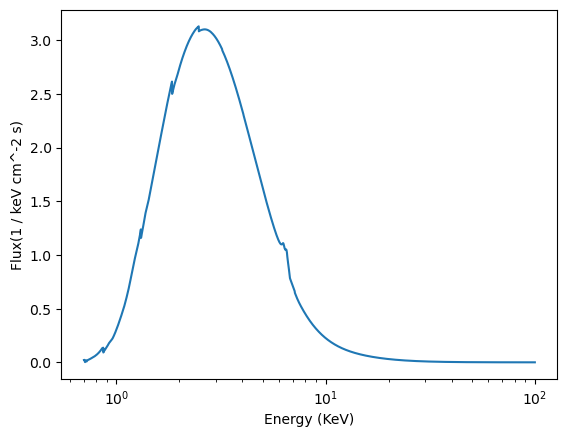

In [13]:
# Clear existing XSPEC models and data
AllModels.clear()
AllData.clear()
AllData.dummyrsp(0.7 ,100.)

# Create the model
model_name = "TBabs*(rdblur*rfxconv*comptb + diskbb + comptb)"
true_model = Model(model_name)

# Set up the energy range of interest for plotting
Plot.device = "/null"
Plot.xAxis = "keV"
Plot.show()
Plot('model')
energy = Plot.x()
true_flux = Plot.model()

plt.plot(energy, true_flux)
plt.xscale("log")
plt.ylabel("Flux(1 / keV cm^-2 s)")
plt.xlabel("Energy (KeV)")

In [15]:
path_to_logs = Path(Path.cwd() / 'logs')
log_dir = path_to_logs / 'fit'
model_file_path = log_dir / 'my_model.h5'

# Load the model
model = load_model(model_file_path, custom_objects={'r_squared': r_squared})
# Load the saved scaler
X_scaler = load(log_dir / 'X_scaler.joblib')
Y_scaler = load(log_dir / 'Y_scaler.joblib')

X_new_scaled = X_scaler.transform([true_flux])

# Make predictions
prediction = model.predict(X_new_scaled)
parameters = Y_scaler.inverse_transform(prediction)

2024-01-09 14:20:00.854175: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


1/1 [==============================] - 6s 6s/step


In [16]:
parameters

array([[ 4.7391348e+00, -1.0764434e+01,  4.7140085e+02,  4.2210472e+01,
        -5.3278267e-01,  1.6714867e+00,  6.0136700e-01,  2.3922615e+00,
        -1.3312198e+00, -1.2990613e-01,  4.1545966e+02,  4.7191043e+19,
         1.5239259e+02]], dtype=float32)

In [26]:
true_model(20).name
start = 20  # Number of the first parameter of comptb_6
for i in range(start, start + len(true_model.comptb_6.parameterNames)):
    print(true_model(i).name)

kTs
gamma
alpha
delta
kTe
log_A
norm


In [72]:
params_dict = {}
for i in range(1, true_model.nParameters+1):
    if not true_model(i).frozen and not true_model(i).link:
        params_dict[str(i)] = true_model(i).values[0]

In [73]:
params_dict

{'1': 1.0,
 '2': -2.0,
 '3': 10.0,
 '5': 30.0,
 '6': -1.0,
 '8': 1.0,
 '10': 1.0,
 '11': 1.0,
 '13': 2.0,
 '15': 5.0,
 '17': 1.0,
 '18': 1.0,
 '19': 1.0}

In [70]:
# Changing default frozen parameters to unfrozen
true_model.rdblur.Betor10.frozen = False
true_model.rdblur.Rout_M.frozen = True
true_model.rdblur.Rin_M.frozen = False
true_model.rfxconv.Fe_abund.frozen = False
true_model.comptb.gamma.frozen = True
true_model.comptb.delta.frozen = True
true_model.comptb.log_A.frozen = True

# Fixing values, upper and lower limits
true_model.TBabs.nH.values = [1.0, 0.01, 0.01, 0.01, 10.0, 10.0]
true_model.rdblur.Betor10.values = [-2, 0.02, -10.0,-10.0, 0,0]
true_model.rfxconv.rel_refl.values = [-1.0, 0.01, -1, -1, 0, 0]
true_model.rfxconv.log_xi.values = [1.0, 0.01, 1.0, 1.0, 4.0, 4.0]
true_model.comptb.alpha.values = [2, 0.02, 0, 0, 3, 3]
true_model.comptb.kTe.values = [5, 0.05, 5, 5, 1000, 1000]

# Linking the parameters
true_model.rfxconv.cosIncl.link = "COSD(5)"

start = 20  # Number of the first parameter of comptb_6
for i in range(start, start + len(true_model.comptb_6.parameterNames)):
    true_model(i).link = true_model(i-9) # 9 is the separation between comptb and comptb_6


  parameter 4 is already frozen.
  parameter 12 is already frozen.


In [71]:
true_model.show()


Model TBabs<1>(rdblur<2>*rfxconv<3>*comptb<4> + diskbb<5> + comptb<6>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   rdblur     Betor10             -2.00000     +/-  0.0          
   3    2   rdblur     Rin_M               10.0000      +/-  0.0          
   4    2   rdblur     Rout_M              1000.00      frozen
   5    2   rdblur     Incl       deg      30.0000      +/-  0.0          
   6    3   rfxconv    rel_refl            -1.00000     +/-  0.0          
   7    3   rfxconv    redshift            0.0          frozen
   8    3   rfxconv    Fe_abund            1.00000      +/-  0.0          
   9    3   rfxconv    cosIncl             0.866025     = COSD(p5)
  10    3   rfxconv    log_xi              1.00000      +/-  0.0          
  11    4   comptb     kTs        keV      1.00000      +/-  0.0          
  12    4   comptb     gamma               3.000